# Project - Deep Learning Based Leak Detection System for Oil pipelines

This code is to train a model based on Convolutional Neural Networks to do prediction.

Team 17.

Team member: Haixia Wu

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

## Load dataset

In [2]:
#fluctuate
df_fluctuate = pd.read_csv("./dataset_resized/dataset_resized_fluctuate.csv")
print(df_fluctuate.shape)

(2837, 66)


In [3]:
#disaster leak
df_fluctuate_leak_disaster = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_disaster.csv")
print(df_fluctuate_leak_disaster.shape)

(2837, 66)


In [4]:
#large leak
df_fluctuate_leak_large = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_large.csv")
print(df_fluctuate_leak_large.shape)

(2837, 66)


In [5]:
#medium leak
df_fluctuate_leak_medium = pd.read_csv("./dataset_resized/dataset_resized_fluctuate_leak_medium.csv")
print(df_fluctuate_leak_medium.shape)

(2837, 66)


In [6]:
#small leak(real)
df_leak_real = pd.read_csv("./dataset_resized/dataset_resized_leak_real.csv")
print(df_leak_real.shape)

(6, 66)


In [7]:
#small leak augment(real)
df_leak_augment = pd.read_csv("./dataset_resized/dataset_resized_leak_augment.csv")
print(df_leak_augment.shape)

(120, 66)


In [8]:
#small leak(artificial synthesis)
df_leak_artificial = pd.read_csv("./dataset_resized/dataset_resized_leak_artificial.csv")
print(df_leak_artificial.shape)

(2244, 66)


In [9]:
#combine these dataset together
df = df_fluctuate.append(df_fluctuate_leak_disaster)\
        .append(df_fluctuate_leak_large).append(df_fluctuate_leak_medium).append(df_leak_real).append(df_leak_augment).append(df_leak_artificial)
df.shape

(13718, 66)

In [10]:
#load each sample from .csv file
X = []
Y = []

for index, row in df.iterrows():
    file_name = row['file_path'] + '.csv'
    dataframe_sample = pd.read_csv(file_name)
    
    curve_dis = (np.array(dataframe_sample['discharge_pressure'])).reshape(len(dataframe_sample['discharge_pressure']),1)
    curve_suc = (np.array(dataframe_sample['suction_pressure'])).reshape(len(dataframe_sample['discharge_pressure']),1)
    curve_combine = np.hstack((curve_dis, curve_suc))
    X.append(curve_combine)

    Y.append(row['label'])
  
X = np.array(X)
print(X.shape)
Y = np.array(Y)
print(Y.shape)

(13718, 3600, 2)
(13718,)


In [11]:
#split data into train, val, test
from sklearn.model_selection import train_test_split

X_dev, X_test, Y_dev, Y_test = train_test_split(X, Y, random_state=37, test_size = 0.2 )
X_train, X_val, Y_train, Y_val = train_test_split(X_dev, Y_dev, random_state=47, test_size = 0.2 )

In [12]:
Y_train_oh = pd.get_dummies(Y_train)# Get one-hot encoding of variable
Y_val_oh = pd.get_dummies(Y_val)
Y_test_oh = pd.get_dummies(Y_test)
Y_train_oh

,fluctuate,leak
0,0,1
1,0,1
2,0,1
3,0,1
4,1,0
...,...,...
8774,0,1
8775,1,0
8776,1,0
8777,0,1


In [13]:
X_train.shape

(8779, 3600, 2)

In [14]:
X_val.shape

(2195, 3600, 2)

In [15]:
X_test.shape

(2744, 3600, 2)

In [16]:
#Define your callbacks (save your model, patience, etc.)
model_name = "best_model_CNN.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [17]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_cnn(ishape = (3600,2,1), k = 2, lr = 1e-4):
    model_input = tf.keras.layers.Input(shape = ishape)
    l1 = tf.keras.layers.Conv2D(128, (10,2), padding='same', activation='relu')(model_input)
    l2 = tf.keras.layers.Conv2D(128, (10,2), padding='same', activation='relu')(l1)
    l2_drop = tf.keras.layers.Dropout(0.25)(l2)
    l3 = tf.keras.layers.Conv2D(256, (10,2), padding='same', activation='relu')(l2_drop)
    l4 = tf.keras.layers.Conv2D(256, (10,2), padding='same', activation='relu')(l3)
    l4_drop = tf.keras.layers.Dropout(0.25)(l4)
    flat = tf.keras.layers.Flatten()(l4_drop)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(flat)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

In [18]:
model = my_model_cnn()
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3600, 2, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 3600, 2, 128)      2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3600, 2, 128)      327808    
_________________________________________________________________
dropout (Dropout)            (None, 3600, 2, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3600, 2, 256)      655616    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3600, 2, 256)      1310976   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3600, 2, 256)      0     

In [19]:
#Train model on TALC

#model.fit(X_train,Y_train_oh,batch_size = 32, epochs = 1000, \
#          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val,Y_val_oh))

In [21]:
#Test model on the test and extract relevant metrics
model.load_weights(model_name)
result = model.evaluate(X_test,Y_test_oh)

86/86 [==============================] - 386s 4s/step - loss: 0.1650 - accuracy: 0.9464


Number of samples predicted wrong:  139


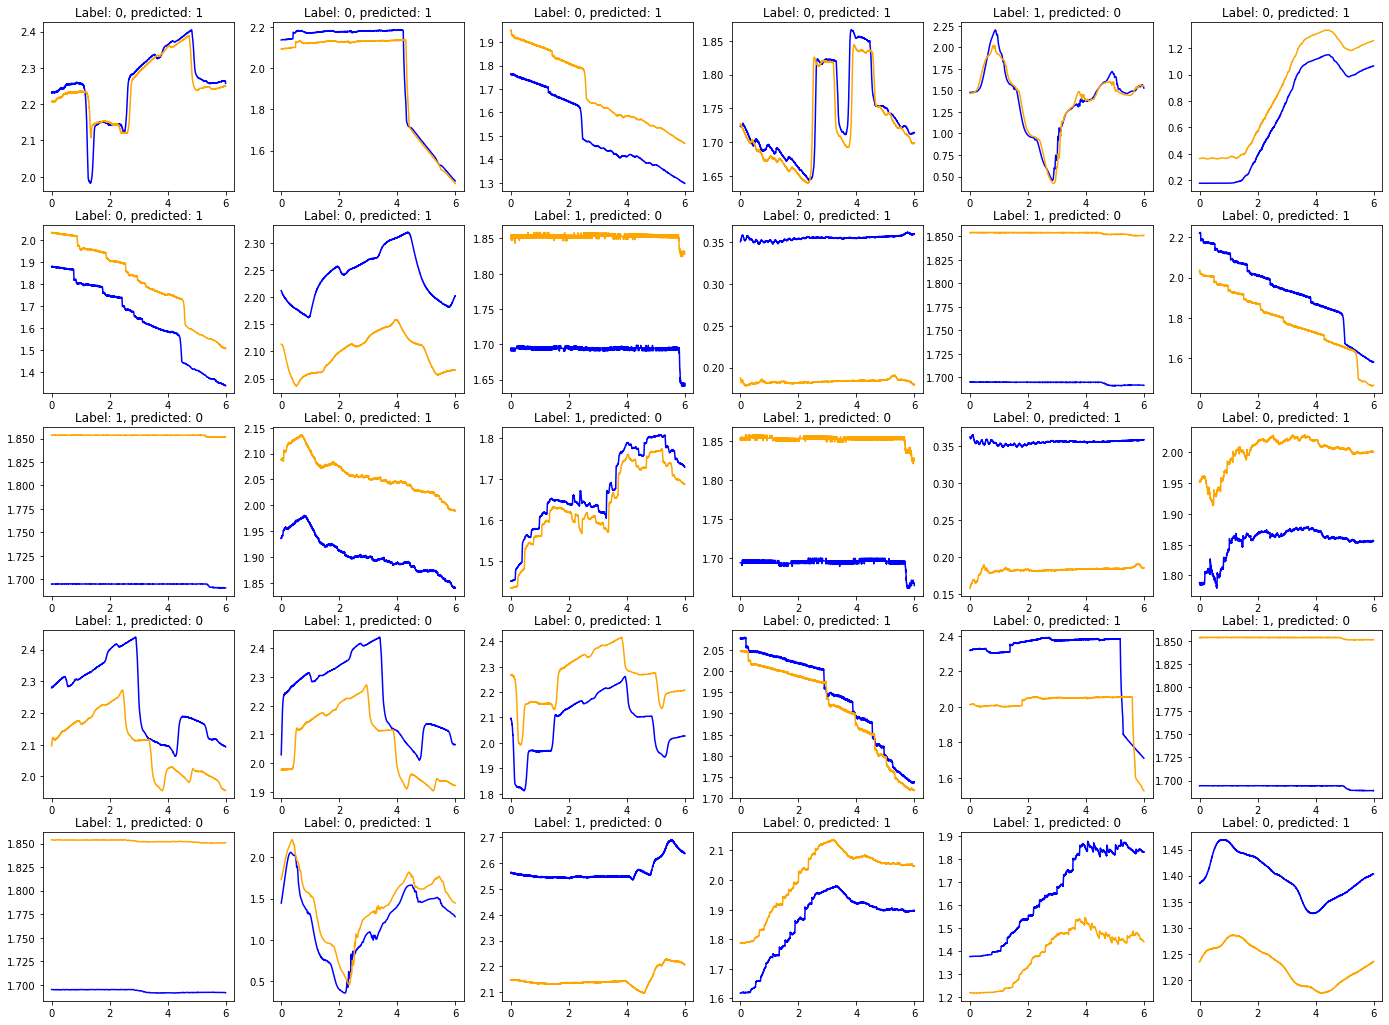

In [22]:
import matplotlib.pylab as plt

Y_test[Y_test == 'fluctuate'] = 0
Y_test[Y_test == 'leak'] = 1
Y_test = Y_test.astype('int64')

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test)[0]
print("Number of samples predicted wrong: ", wrong_indexes.size)

# Disaplying wrong prediction samples in test dataset
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    discharge_curve = X_test[wrong_indexes[jj]][:, 0]
    suction_curve = X_test[wrong_indexes[jj]][:, 1]
    time = np.arange(0, 6, 1/600) # 6 minutes
    line_discharge = plt.plot(time, X_test[wrong_indexes[jj]][:, 0], c = 'blue', label="discharge") 
    line_suction = plt.plot(time, X_test[wrong_indexes[jj]][:, 1], c = 'orange', label="suction") 
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()